In [1]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [2]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [3]:
from datasets import load_dataset

dataset = load_dataset("xtreme", name="PAN-X.te")

Found cached dataset xtreme (/u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict
from datasets import DatasetDict 

langs = ["hi", "te", "ta", "en"]
fracs = [0.5709, 0.0777, 0.6360, 0.1067]
fracs = [frac / sum(fracs) for frac in fracs]
# return a DatasetDict if a key does not exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # load multilingual corpus 
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=42)
            .select(range(int(frac * ds[split].num_rows)))
        )

Found cached dataset xtreme (/u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.hi/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.hi/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-68314036533271e4.arrow
Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.hi/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-8dbe0c17aec505e3.arrow
Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.hi/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-16c4e170f4c083d6.arrow
Found cached dataset xtreme (/u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-021189a66c8ca2fc.arrow
Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-a6dd7522f39237eb.arrow
Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-fb8462d1a7a7ec54.arrow
Found cached dataset xtreme (/u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-6ce4719467e98050.arrow
Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-ba0404565ea374a4.arrow
Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-29467d2078f2faf4.arrow
Found cached dataset xtreme (/u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e14b50505509ca06.arrow
Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-529925d4984531e4.arrow
Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-ef60137063549caf.arrow


In [5]:
import pandas as pd 

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs}, 
             index=["Number of training examples"])

,hi,te,ta,en
Number of training examples,2051,55,6856,1533


In [6]:
element = panx_ch["hi"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['प्रेम', 'चोपड़ा', '-', 'गिरिधारीलाल']
ner_tags: [1, 2, 0, 0]
langs: ['hi', 'hi', 'hi', 'hi']


In [7]:
for key, value in panx_ch["hi"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [8]:
tags = panx_ch["hi"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [9]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch['ner_tags']]}

panx_hi = panx_ch["hi"].map(create_tag_names)

Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.hi/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-a5e82638fe2cec57.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.hi/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-a4af9bc9df139198.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.hi/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-8fa5e26de647100a.arrow


In [10]:
hi_example = panx_hi["train"][0]
pd.DataFrame([hi_example["tokens"], hi_example["ner_tags_str"]], ['Tokens', 'Tags'])

,0,1,2,3
Tokens,प्रेम,चोपड़ा,-,गिरिधारीलाल
Tags,B-PER,I-PER,O,O


In [11]:
from collections import Counter 

split2freqs = defaultdict(Counter)
for split, dataset in panx_hi.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1 

pd.DataFrame.from_dict(split2freqs, orient="index")

,PER,ORG,LOC
train,945,753,790
validation,177,140,185
test,158,151,176


Multilingual transformers

In [12]:
from transformers import AutoTokenizer 

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [13]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [14]:
bert_tokens

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']

In [15]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

In [16]:
# whitespace is preserved by using xlmr which uses the SentencePiece tokenizer
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

## Transformers for Named Entity Recognition

In [17]:
import torch.nn as nn 
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

In [18]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super(XLMRobertaForTokenClassification, self).__init__(config)
        self.num_labels = config.num_labels
        # load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # set up token classification head 
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # load and initialize weights 
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        # apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # calculate losses 
        loss = None 
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # return model output object 
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )



## Loading a Custom Model

In [19]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [20]:
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [21]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

In [22]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'roberta

In [23]:
# test on a small sequence of known entities 
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [24]:
outputs = xlmr_model(input_ids.to(device)).logits 
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(F"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [25]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,B-ORG


In [26]:
def tag_text(text, tags, model, tokenizer):
    # get tokens with special characters
    tokens = tokenizer(text).tokens()
    # encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # get predictions as a distribution over 7 possible classes 
    outputs = model(input_ids)[0]
    # take argmax to get most likely class per token 
    predictions = torch.argmax(outputs, dim=2)
    # convert to dataframe
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

## Tokenizing Texts for NER

In [27]:
words, labels = hi_example["tokens"], hi_example["ner_tags"]

In [28]:
tokenized_input = xlmr_tokenizer(hi_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7
Tokens,<s>,▁प्रेम,▁चोपड़ा,▁-,▁गिरि,धारी,लाल,</s>


In [29]:
# need to mask the subwords after the first subword
word_ids = tokenized_input.word_ids() 
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7
Tokens,<s>,▁प्रेम,▁चोपड़ा,▁-,▁गिरि,धारी,लाल,</s>
Word IDs,None,0,1,2,3,3,3,None


In [30]:
previous_word_idx = None 
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in labels]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7
Tokens,<s>,▁प्रेम,▁चोपड़ा,▁-,▁गिरि,धारी,लाल,</s>
Word IDs,None,0,1,2,3,3,3,None
Label IDs,-100,1,2,0,0,-100,-100,-100
Labels,B-PER,I-PER,O,O,None,None,None,None


In [31]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = [] 
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None 
        label_ids = [] 
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels 
    return tokenized_inputs

In [32]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])

panx_hi_encoded = encode_panx_dataset(panx_ch["hi"])

Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.hi/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-a268d1bbb148d385.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.hi/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-b9fb3bcaedd13b7d.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.hi/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-7742a222018ea25d.arrow


In [33]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [34]:
import numpy as np 

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], [] 

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], [] 
        for seq_idx in range(seq_len):
            # ignore label ids = -100 
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

    

## Fine-tuning XLM-RoBERTa

In [35]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_hi_encoded["train"]) // batch_size 
model_name = f"{xlmr_model_name}-finetuned-panx-hi"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True
)

In [36]:
from huggingface_hub import notebook_login 

notebook_login()

In [37]:
from seqeval.metrics import f1_score 

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [38]:
from transformers import DataCollatorForTokenClassification 

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [39]:
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

In [40]:
from transformers import Trainer 

trainer = Trainer(model_init=model_init, args=training_args, data_collator=data_collator, compute_metrics=compute_metrics,
                   train_dataset=panx_hi_encoded["train"], eval_dataset=panx_hi_encoded["validation"], tokenizer=xlmr_tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/u/akommala/nlp-with-transformers/xlm-roberta-base-finetuned-panx-hi is already a clone of https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-hi. Make sure you pull the latest changes with `repo.git_pull()`.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [41]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.430049,0.656420
2,0.716200,0.303167,0.802337
3,0.716200,0.279025,0.829746


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.50k [00:00<?, ?B/s]

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-hi
   b74918b..b7e49ba  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

'https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-hi/commit/b7e49ba67e9a0b3a867eaa0f9303b6d935554379'

In [42]:
text_hi = "तेजी बच्चन से अमिताभ तथा अजिताभ दो पुत्र हुए ।"
tag_text(text_hi, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁तेजी,▁बच्चन,▁से,▁अमिताभ,▁तथा,▁अज,िता,भ,▁दो,▁पुत्र,▁हुए,▁।,</s>
Tags,O,B-PER,I-PER,O,B-PER,O,B-PER,I-PER,I-PER,O,O,O,O,O


## Error Analysis

In [43]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # convert dict of lists of list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size [batch_size, sequence_length, classes]
        # predict class with largest logit value on classes axis 
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy() 
    
    # calculate loss per token after flattening batch dimension with view 
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none") 
    # unflatten batch dimension and convert to numpy array 
    loss = loss.view(len(input_ids), -1).cpu().numpy() 
    
    return {'loss': loss, 'predicted_label': predicted_label}

In [44]:
valid_set = panx_hi_encoded["validation"] 
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7fd9d0871280> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/410 [00:00<?, ? examples/s]

In [45]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x]) 
df["loss"] = df.apply(
    lambda x: x["loss"][:len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1)
df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 2218, 14136, 5988, 67691, 460, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.03533609, 0.0, 0.027601829, 0.02570483...","[O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O]","[<s>, ▁स, जन, ▁घर, ▁जाना, ▁है, </s>]"
1,"[0, 93019, 7475, 976, 156711, 41612, 3558, 967...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, IGN, IGN, IGN, B-PER, IGN, IGN, IGN, ...","[0.0, 0.0056619984, 0.0, 0.0, 0.0, 0.019219365...","[O, O, O, O, O, B-PER, I-PER, I-PER, I-PER, I-...","[<s>, ▁पुनर्, प्र, े, षित, ▁फ़, ि, रो, ज़, ▁शा..."
2,"[0, 11026, 3849, 8389, 1471, 871, 76302, 659, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-LOC, IGN, IGN, IGN, I-LOC, I-LOC, IGN,...","[0.0, 0.07252373, 0.0, 0.0, 0.0, 0.05340195, 0...","[I-LOC, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-L...","[<s>, ▁ला, ह, ौ, ल, ▁और, ▁स्प, ी, ति, ▁जिला, <..."
3,"[0, 20571, 3282, 6, 150685, 20, 3813, 1187, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-PER, IGN, I-PER, IGN, O, O, IGN, IGN, ...","[0.0, 0.012027361, 0.0, 0.016277391, 0.0, 0.00...","[O, B-PER, I-PER, I-PER, I-PER, O, O, O, O, O]","[<s>, ▁अस, ित, ▁, सेन, ▁-, ▁था, ने, दार, </s>]"
4,"[0, 9163, 2629, 76183, 1472, 6, 4, 46005, 1187...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-LOC, IGN, IGN, IGN, I-LOC, IGN, I-LOC,...","[0.0, 0.055613037, 0.0, 0.0, 0.0, 1.1047724, 0...","[I-LOC, B-LOC, B-LOC, I-LOC, I-LOC, O, O, B-LO...","[<s>, ▁मे, म्, फि, स, ▁, ,, ▁टे, ने, सी, </s>]"


In [46]:
df_tokens = df.apply(pd.Series.explode) 
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2) 
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,2218,1,B-ORG,0.04,B-ORG,▁स
0,5988,1,I-ORG,0.03,I-ORG,▁घर
0,67691,1,I-ORG,0.03,I-ORG,▁जाना
0,460,1,I-ORG,0.03,I-ORG,▁है
1,93019,1,O,0.01,O,▁पुनर्
1,41612,1,B-PER,0.02,B-PER,▁फ़
1,51757,1,I-PER,0.03,I-PER,▁शाह


In [47]:
(df_tokens.groupby("input_tokens")[["loss"]]
 .agg(["count", "mean", "sum"])
 .droplevel(level=0, axis=1)
 .sort_values(by="sum", ascending=False)
 .reset_index()
 .round(2)
 .head(10)
 .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁),▁(,▁का,▁सी,▁डी,▁क्रिकेट,▁राज्य,▁N,▁पाठ्यक्रम
count,235,80,80,39,7,6,4,9,1,1
mean,0.32,0.42,0.41,0.32,1.3,1.37,1.93,0.75,6.07,5.71
sum,74.51,33.85,32.66,12.56,9.11,8.21,7.71,6.71,6.07,5.71


In [48]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-ORG,I-LOC,O,I-PER,B-LOC,B-ORG,B-PER
count,407,163,976,259,185,140,177
mean,0.34,0.74,0.12,0.3,0.39,0.47,0.25
sum,138.0,120.02,119.42,78.68,72.38,65.3,43.59


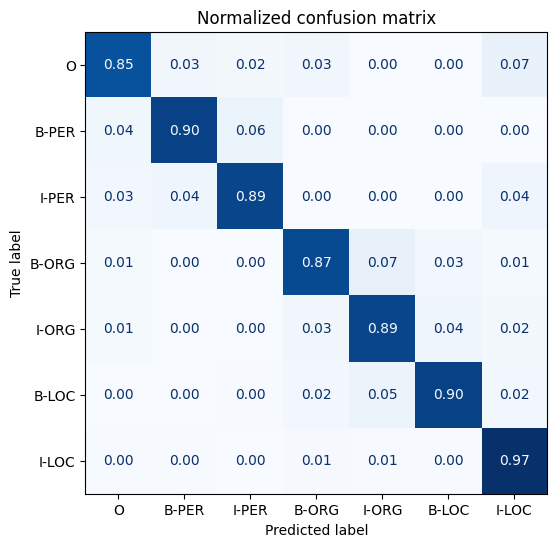

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show() 
    
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

In [50]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], [] 
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels":labels, "preds": preds, "losses": losses}).T

        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6
tokens,▁चिन,▁राज्य,▁(,▁प्राचीन,▁चीन,▁),</s>
labels,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,2.65,3.74,2.91,3.49,3.69,2.87,0.00


,0,1,2,3,4,5,6,7
tokens,▁एन,एस,ई,▁(,▁N,SE,▁),</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,IGN,I-ORG,IGN
preds,O,O,O,O,O,O,O,O
losses,1.83,0.00,0.00,5.81,6.07,0.00,5.62,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁,विद,र्,भ,▁क्रिकेट,▁एस,ोस,िए,शन,▁,ग्रा,उ,ंड,▁,",",▁नाग,पुर,</s>
labels,B-LOC,IGN,IGN,IGN,I-LOC,I-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,IGN,O,IGN,B-LOC,IGN,IGN
preds,B-ORG,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,B-LOC,I-ORG,O
losses,3.21,0.00,0.00,0.00,4.73,4.71,0.00,0.00,0.00,3.86,0.00,0.00,0.00,1.10,0.00,0.36,0.00,0.00


In [51]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample) 

,0,1,2,3,4,5,6,7,8,9,10,11
tokens,▁मिल,ो,रा,ड,▁म,ज़,िक,▁(,▁सर्,बिया,▁),</s>
labels,O,IGN,IGN,IGN,O,IGN,IGN,O,B-LOC,IGN,O,IGN
preds,B-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,O,B-LOC,I-LOC,I-PER,O
losses,5.18,0.00,0.00,0.00,4.01,0.00,0.00,0.55,0.43,0.00,0.95,0.00


,0,1,2,3,4,5,6,7,8,9
tokens,▁राजेन्द्र,▁सिंह,▁(,▁र,ज्,जू,▁भै,या,▁),</s>
labels,B-PER,I-PER,I-PER,I-PER,IGN,IGN,I-PER,IGN,I-PER,IGN
preds,B-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,O
losses,0.03,0.02,0.55,0.82,0.00,0.00,0.04,0.00,0.45,0.00


## Cross Lingual Transfer

In [52]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [54]:
f1_scores = defaultdict(dict)
f1_scores["hi"]["hi"] = get_f1_score(trainer, panx_hi_encoded["test"])
print(f"F1-score of [hi] model on [hi] dataset: {f1_scores['hi']['hi']:.3f}")

/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


F1-score of [hi] model on [hi] dataset: 0.762


In [58]:
text_te = "నా అమ్మ కళ్లకు నీళ్ళు పోయాయి"
tag_text(text_te, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10
Tokens,<s>,▁నా,▁అమ్మ,▁క,ళ్ల,కు,▁నీ,ళ్ళు,▁,పోయాయి,</s>
Tags,O,B-PER,I-PER,I-ORG,I-ORG,O,O,O,O,O,O


In [59]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [62]:
f1_scores["hi"]["te"] = evaluate_lang_performance("te", trainer)
f1_scores["hi"]["ta"] = evaluate_lang_performance("ta", trainer)
f1_scores["hi"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [hi] model pn [te] dataset: {f1_scores['hi']['te']:.3f}")
print(f"F1-score of [hi] model pn [ta] dataset: {f1_scores['hi']['ta']:.3f}")
print(f"F1-score of [hi] model pn [en] dataset: {f1_scores['hi']['en']:.3f}")

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-0a9be84a8e490af0.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-7a1e4f78c3e1049a.arrow


Map:   0%|          | 0/6856 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

Map:   0%|          | 0/1533 [00:00<?, ? examples/s]

Map:   0%|          | 0/766 [00:00<?, ? examples/s]

Map:   0%|          | 0/766 [00:00<?, ? examples/s]

F1-score of [hi] model pn [te] dataset: 0.517
F1-score of [hi] model pn [ta] dataset: 0.544
F1-score of [hi] model pn [en] dataset: 0.505


In [65]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples)) 
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size 
    
    trainer = Trainer(model_init=model_init, args=training_args,
                      data_collator=data_collator, compute_metrics=compute_metrics,
                      train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train() 
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!") 
        
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [66]:
panx_ta_encoded = encode_panx_dataset(panx_ch["ta"])
training_args.push_to_hub = False 
metrics_df = train_on_subset(panx_ta_encoded, 250)
metrics_df

Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-0b1a043e5fbd9bc3.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-1251990df669ce8b.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-b75ff5749b911307.arrow
Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5eca1d3cb0a1cf30.arrow


Epoch,Training Loss,Validation Loss,F1
1,No log,1.323507,0.000000
2,1.739300,1.146330,0.013675
3,1.739300,1.073598,0.022913


,num_samples,f1_score
0,250,0.009852


In [74]:
for num_samples in [500, 1000, 2000, 4000]:
    result = train_on_subset(panx_ta_encoded, num_samples)
    metrics_df = pd.concat([metrics_df, result], ignore_index=True)

Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5eca1d3cb0a1cf30.arrow
/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,1.156404,0.006192
2,1.466300,0.987687,0.137143
3,1.466300,0.902659,0.164493


Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5eca1d3cb0a1cf30.arrow


Epoch,Training Loss,Validation Loss,F1
1,No log,0.859298,0.179732
2,1.092700,0.545415,0.525869
3,1.092700,0.467190,0.572635


Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5eca1d3cb0a1cf30.arrow


Epoch,Training Loss,Validation Loss,F1
1,No log,0.678037,0.438784
2,0.913000,0.349452,0.685714
3,0.913000,0.328346,0.710345


Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5eca1d3cb0a1cf30.arrow


Epoch,Training Loss,Validation Loss,F1
1,No log,0.335882,0.674699
2,0.522800,0.252491,0.751547
3,0.522800,0.248702,0.774423


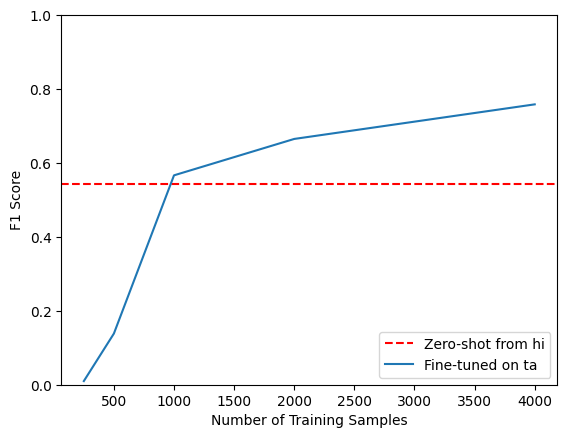

In [75]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["hi"]["ta"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax) 
plt.legend(["Zero-shot from hi", "Fine-tuned on ta"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

## Fine-Tuning on Multiple Languages at Once

In [76]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus 

In [78]:
panx_hi_ta_encoded = concatenate_splits([panx_hi_encoded, panx_ta_encoded])

In [80]:
training_args.logging_steps = len(panx_hi_ta_encoded["train"]) // batch_size 
training_args.push_to_hub = True 
training_args.output_dir = "xlm-roberta-base-finetuned-panx-hi-ta"

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics, 
                  tokenizer=xlmr_tokenizer, train_dataset=panx_hi_ta_encoded["train"],
                  eval_dataset=panx_hi_ta_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-hi-ta into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.317362,0.767963
2,0.391900,0.236424,0.806194
3,0.391900,0.219470,0.838800


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.56k [00:00<?, ?B/s]

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-hi-ta
   686f941..eb18e8b  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-hi-ta
   eb18e8b..529deb3  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-hi-ta/commit/eb18e8b770057b0656e39058767994d9bd50058b'

In [81]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [hi-fa] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/2051 [00:00<?, ? examples/s]

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-77e21bc76f53307c.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-0a9be84a8e490af0.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-7a1e4f78c3e1049a.arrow


F1-score of [hi-fa] model on [hi] dataset: 0.817


Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-0b1a043e5fbd9bc3.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-1251990df669ce8b.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-b75ff5749b911307.arrow


F1-score of [hi-fa] model on [te] dataset: 0.577


Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-26c09d9e10a651a1.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-722ed6e24115ceef.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-be4fd7323f8961aa.arrow


F1-score of [hi-fa] model on [ta] dataset: 0.798


F1-score of [hi-fa] model on [en] dataset: 0.389


In [82]:
corpora = [panx_hi_encoded] 

# exclude hindi from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # fine-tune on monolingual corpus 
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # collect F1-scores in common dict 
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-77e21bc76f53307c.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-0a9be84a8e490af0.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.te/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-7a1e4f78c3e1049a.arrow


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-te into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,2.342200,2.132988,0.070652
2,1.953400,1.635856,0.036364
3,1.729000,1.380958,0.000000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.56k [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-te
   83c8508..85cd866  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-te
   85cd866..011be9d  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-0b1a043e5fbd9bc3.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-1251990df669ce8b.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-b75ff5749b911307.arrow
Loading cached shuffled indices for dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.ta/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5eca1d3cb0a1cf30.arrow


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-ta into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.285014,0.741187
2,0.401300,0.225861,0.778761
3,0.401300,0.222329,0.807520


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.56k [00:00<?, ?B/s]

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-ta
   0b7047d..bfd21e5  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-ta
   bfd21e5..a0288f6  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-26c09d9e10a651a1.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-722ed6e24115ceef.arrow
Loading cached processed dataset at /u/akommala/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-be4fd7323f8961aa.arrow


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-en into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.651563,0.501952
2,0.901000,0.428605,0.647899
3,0.901000,0.406697,0.666099


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.56k [00:00<?, ?B/s]

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-en
   c6a517b..a0bd435  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-en
   a0bd435..8306f52  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [83]:
corpora_encoded = concatenate_splits(corpora)

In [84]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size 
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
                  eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-all into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.329411,0.719106
2,0.401200,0.303813,0.758561
3,0.401200,0.292166,0.780616


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.56k [00:00<?, ?B/s]

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-all
   5beabd0..bf50281  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-all
   bf50281..d92ec7e  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/akommala/xlm-roberta-base-finetuned-panx-all/commit/bf5028133d5edd94a2553e79a72d7a9d594bce35'

In [85]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])
scores_data = {"hi": f1_scores["hi"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on", 
                         inplace=True)
f1_scores_df

/u/akommala/nlp-with-transformers/env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Evaluated on,hi,te,ta,en
Fine-tune on,,,,
hi,0.7615,0.5170,0.5441,0.5049
each,0.7615,0.0270,0.7742,0.6812
all,0.8032,0.6099,0.8109,0.7442
